# CS144 Ping/Traceroute Analysis
#### Nicholas Allen
#### nallen21 

Here I visualize and answer questions 1 - 13 in CS144 checkpoint 4. Transmission data is stored in `data/transmission_data/` and traceroutes in `data/traceroute_data/`. I sent transmissions to the university of Queensland Australia at www.uq.edu.au and university of southern california at www.usc.edu. I did a total of 5 different test types all well over an hour.
- USC + Wifi (close and wireless intersting connection)
- USC + Myth (closed and wired)
- Australia + Wifi (far and wireless interesting)
- Australia + Cellular (far and wireless interesting)
- Australia + Myth (far and wired)


In [25]:
from __future__ import annotations
import re
import os
from dataclasses import dataclass
from typing import List, Optional, Tuple
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context="notebook", style="whitegrid")

DATA_ROOT = "/Users/nickallen/Documents/GitHub/CS144/data"
TX_DIR = os.path.join(DATA_ROOT, "transmission_data")
TR_DIR = os.path.join(DATA_ROOT, "traceroute_data")

@dataclass
class PingSample:
    seq: int
    rtt_ms: Optional[float]
    success: bool
    epoch_ts: Optional[float]

LINUX_PING_RE = re.compile(r"^\[(?P<ts>\d+\.\d+)\]\s+64 bytes from .*icmp_seq=(?P<seq>\d+) .* time=(?P<rtt>[\d\.]+) ms$")
MAC_PING_RE = re.compile(r"^64 bytes from .*icmp_seq=(?P<seq>-?\d+) .* time=(?P<rtt>[\d\.]+) ms$")
MAC_TIMEOUT_RE = re.compile(r"^Request timeout for icmp_seq (?P<seq>-?\d+)$")


def parse_ping_file(path: str) -> pd.DataFrame:
    """Parse a ping output file into a DataFrame with columns:
    ['seq','rtt_ms','success','epoch_ts'] sorted by seq.
    Handles Linux (with leading [epoch]) and macOS formats.
    """
    samples: List[PingSample] = []
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            m = LINUX_PING_RE.match(line)
            if m:
                samples.append(PingSample(
                    seq=int(m.group("seq")),
                    rtt_ms=float(m.group("rtt")),
                    success=True,
                    epoch_ts=float(m.group("ts")),
                ))
                continue
            m = MAC_PING_RE.match(line)
            if m:
                samples.append(PingSample(
                    seq=int(m.group("seq")),
                    rtt_ms=float(m.group("rtt")),
                    success=True,
                    epoch_ts=None,
                ))
                continue
            m = MAC_TIMEOUT_RE.match(line)
            if m:
                samples.append(PingSample(
                    seq=int(m.group("seq")),
                    rtt_ms=None,
                    success=False,
                    epoch_ts=None,
                ))
                continue
            # ignore header or other lines
    df = pd.DataFrame([s.__dict__ for s in samples])
    if df.empty:
        return df
    df = df.sort_values("seq").reset_index(drop=True)
    # Create relative time if epoch present and mostly filled
    if df["epoch_ts"].notna().mean() > 0.5:
        t0 = df["epoch_ts"].dropna().iloc[0]
        df["t_sec"] = df["epoch_ts"].fillna(method="ffill").fillna(method="bfill") - t0
    else:
        # approximate assuming 1s spacing
        df["t_sec"] = (df["seq"] - df["seq"].min()).astype(float)
    return df


def longest_streak(series: pd.Series, target: bool) -> int:
    best = cur = 0
    for val in series:
        if bool(val) == target:
            cur += 1
            best = max(best, cur)
        else:
            cur = 0
    return best


def packet_loss_autocorr(success_series: pd.Series, k_values: List[int]) -> pd.DataFrame:
    """Conditional delivery rates given success/loss at offset k.
    Returns DataFrame with columns ['k','P(reply|reply)','P(loss|loss)'] with NaNs when undefined.
    """
    x = success_series.astype(int).to_numpy()
    out = []
    n = len(x)
    for k in k_values:
        if k == 0:
            out.append((k, np.nan, np.nan))
            continue
        if k > 0:
            a = x[:-k]
            b = x[k:]
        else:
            a = x[-k:]
            b = x[:k]
        # P(reply_{n+k}=1 | reply_n=1)
        mask_reply = a == 1
        mask_loss = a == 0
        pr = b[mask_reply].mean() if mask_reply.any() else np.nan
        pl = (1 - b[mask_loss]).mean() if mask_loss.any() else np.nan
        out.append((k, pr, pl))
    return pd.DataFrame(out, columns=["k", "P_reply_given_reply", "P_loss_given_loss"])


In [26]:
# Load all ping datasets
from glob import glob

ping_files = sorted(glob(os.path.join(TX_DIR, "*.txt")))
{pf: os.path.basename(pf) for pf in ping_files}


{'/Users/nickallen/Documents/GitHub/CS144/data/transmission_data/computer_to_australia_stanfod_hotspot_data.txt': 'computer_to_australia_stanfod_hotspot_data.txt',
 '/Users/nickallen/Documents/GitHub/CS144/data/transmission_data/computer_to_australia_stanfod_wifi_data.txt': 'computer_to_australia_stanfod_wifi_data.txt',
 '/Users/nickallen/Documents/GitHub/CS144/data/transmission_data/labtop_to_usc_stanford_wifi.txt': 'labtop_to_usc_stanford_wifi.txt',
 '/Users/nickallen/Documents/GitHub/CS144/data/transmission_data/myth_to_australia_data.txt': 'myth_to_australia_data.txt',
 '/Users/nickallen/Documents/GitHub/CS144/data/transmission_data/usc_myth_data.txt': 'usc_myth_data.txt'}

In [27]:
# Parse and combine to a single DataFrame with a dataset label
frames = []
for pf in ping_files:
    df = parse_ping_file(pf)
    df["dataset"] = os.path.basename(pf)
    frames.append(df)

pings = pd.concat(frames, ignore_index=True)
pings.head()


/var/folders/jl/kxty9ftx6jz4jnztx5wctvt40000gn/T/ipykernel_49497/3313088552.py:75: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["t_sec"] = df["epoch_ts"].fillna(method="ffill").fillna(method="bfill") - t0
/var/folders/jl/kxty9ftx6jz4jnztx5wctvt40000gn/T/ipykernel_49497/3313088552.py:75: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["t_sec"] = df["epoch_ts"].fillna(method="ffill").fillna(method="bfill") - t0
/var/folders/jl/kxty9ftx6jz4jnztx5wctvt40000gn/T/ipykernel_49497/2860007488.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pings = pd.concat(frames, 

,seq,rtt_ms,success,epoch_ts,t_sec,dataset
0,0,NaN,False,NaN,0.0,computer_to_australia_stanfod_hotspot_data.txt
1,0,218.535,True,NaN,0.0,computer_to_australia_stanfod_hotspot_data.txt
2,1,215.867,True,NaN,1.0,computer_to_australia_stanfod_hotspot_data.txt
3,2,201.771,True,NaN,2.0,computer_to_australia_stanfod_hotspot_data.txt
4,3,211.031,True,NaN,3.0,computer_to_australia_stanfod_hotspot_data.txt


## Q1. Overall delivery rate over entire interval
Delivery rate = number of echo replies received / number of echo requests sent. Missing sequence numbers indicate lost replies.


In [28]:
def compute_delivery_rate(df: pd.DataFrame) -> float:
    if df.empty:
        return float("nan")
    seq_min, seq_max = int(df["seq"].min()), int(df["seq"].max())
    total_sent = seq_max - seq_min + 1
    received = int(df["success"].sum())
    return received / total_sent

rates = pings.groupby("dataset").apply(compute_delivery_rate).rename("delivery_rate").reset_index()
rates


/var/folders/jl/kxty9ftx6jz4jnztx5wctvt40000gn/T/ipykernel_49497/2137780500.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rates = pings.groupby("dataset").apply(compute_delivery_rate).rename("delivery_rate").reset_index()


,dataset,delivery_rate
0,computer_to_australia_stanfod_hotspot_data.txt,0.999464
1,computer_to_australia_stanfod_wifi_data.txt,1.000000
2,labtop_to_usc_stanford_wifi.txt,5.333740
3,myth_to_australia_data.txt,0.999968
4,usc_myth_data.txt,1.000000


## Q2. Longest consecutive string of successful pings


In [29]:
success_streaks = (
    pings.sort_values(["dataset","seq"]) 
         .groupby("dataset")["success"].apply(lambda s: longest_streak(s, True))
         .rename("longest_success_streak")
         .reset_index()
)
success_streaks


,dataset,longest_success_streak
0,computer_to_australia_stanfod_hotspot_data.txt,6289
1,computer_to_australia_stanfod_wifi_data.txt,17893
2,labtop_to_usc_stanford_wifi.txt,23655
3,myth_to_australia_data.txt,30970
4,usc_myth_data.txt,202


## Q3. Longest burst of losses


In [30]:
loss_streaks = (
    pings.sort_values(["dataset","seq"]) 
         .groupby("dataset")["success"].apply(lambda s: longest_streak(s, False))
         .rename("longest_loss_burst")
         .reset_index()
)
loss_streaks


,dataset,longest_loss_burst
0,computer_to_australia_stanfod_hotspot_data.txt,1
1,computer_to_australia_stanfod_wifi_data.txt,1
2,labtop_to_usc_stanford_wifi.txt,1
3,myth_to_australia_data.txt,0
4,usc_myth_data.txt,0


## Q4. Geographic path from traceroute


In [31]:
# Summarize visible named hops per traceroute file
from collections import defaultdict

trace_files = sorted(glob(os.path.join(TR_DIR, "*.txt")))
tr_summaries = {}
for tf in trace_files:
    hops = []
    with open(tf, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("traceroute "):
                continue
            if "* * *" in line:
                continue
            # capture the hostname/ip in parentheses if present
            parts = line.split()
            if len(parts) >= 2:
                hops.append(" ".join(parts[1:3]))
    tr_summaries[os.path.basename(tf)] = hops
tr_summaries


{'laptop_to_australia_traceroute.txt': ['10.27.112.2 (10.27.112.2)',
  'xb-east-rtr-vlan11.sunet (171.64.0.194)',
  'hpr-svl-rtr-vlan3.sunet (171.66.255.147)',
  'hpr-svl-hpr3--stan-100ge.cenic.net (137.164.27.60)',
  'aarnet-2-is-jmb-778.sttlwa.pacificwave.net (207.231.245.4)',
  'et-10-0-5.170.pe1.brwy.nsw.aarnet.net.au (113.197.15.62)',
  'et-7-1-0.pe1.brwy.nsw.aarnet.net.au (113.197.15.13)',
  'et-0-3-0.pe1.gdpt.qld.aarnet.net.au (113.197.15.17)',
  '138.44.129.158 (138.44.129.158)',
  'fw-a-gw10.router.uq.edu.au (130.102.0.193)',
  'se10-fw-a.router.uq.edu.au (130.102.159.61)',
  'www-test.uq.edu.au (130.102.184.3)'],
 'laptop_to_usc_traceroute.txt': ['10.27.112.2 (10.27.112.2)',
  'xb-east-rtr-vlan11.sunet (171.64.0.194)',
  'dc-sf-rtr-vl2.sunet (171.64.255.146)',
  '(171.66.255.146) 3.550',
  'dc-sfo-agg4--stanford-100g.cenic.net (137.164.23.178)',
  'dc-snvl2-agg-01--sfra1-agg-01-100gbe.cenic.net (137.164.11.92)',
  'dc-svl-agg10--snvl2-agg-01-400g.cenic.net (137.164.11.80)'],


### Readable traceroute summary (all hops)


In [32]:
# Pretty-print full traceroutes with all hops, preserving '*' lines
from textwrap import shorten

for tf in sorted(glob(os.path.join(TR_DIR, "*.txt"))):
    print(f"\n=== {os.path.basename(tf)} ===")
    with open(tf, "r", encoding="utf-8", errors="ignore") as f:
        hop_num = 0
        for raw in f:
            line = raw.rstrip("\n")
            if not line or line.startswith("traceroute "):
                continue
            hop_num += 1
            # collapse extra spaces for readability but keep stars
            cleaned = " ".join(line.split())
            print(f"{hop_num:>2}: {cleaned}")



=== laptop_to_australia_traceroute.txt ===
 1: 1 10.27.112.2 (10.27.112.2) 3.651 ms 3.235 ms 2.117 ms
 2: 2 xb-east-rtr-vlan11.sunet (171.64.0.194) 3.217 ms 2.609 ms 3.986 ms
 3: 3 hpr-svl-rtr-vlan3.sunet (171.66.255.147) 6.783 ms 3.189 ms 4.382 ms
 4: 4 hpr-svl-hpr3--stan-100ge.cenic.net (137.164.27.60) 4.615 ms 3.316 ms 3.399 ms
 5: 5 aarnet-2-is-jmb-778.sttlwa.pacificwave.net (207.231.245.4) 19.882 ms 20.543 ms 21.804 ms
 6: 6 et-10-0-5.170.pe1.brwy.nsw.aarnet.net.au (113.197.15.62) 234.173 ms 159.678 ms 157.617 ms
 7: 7 et-7-1-0.pe1.brwy.nsw.aarnet.net.au (113.197.15.13) 200.378 ms 218.672 ms 157.709 ms
 8: 8 et-0-3-0.pe1.gdpt.qld.aarnet.net.au (113.197.15.17) 172.916 ms 176.652 ms 172.709 ms
 9: 9 138.44.129.158 (138.44.129.158) 177.420 ms 174.549 ms 174.031 ms
10: 10 fw-a-gw10.router.uq.edu.au (130.102.0.193) 201.512 ms 180.045 ms 224.624 ms
11: 11 se10-fw-a.router.uq.edu.au (130.102.159.61) 263.520 ms 174.616 ms 173.740 ms
12: 12 * * *
13: 13 * * *
14: 14 * * *
15: 15 * * *
16:

I was unable to deduce the path by using the traceroute. However, for every route we can see the packages leaving stanford with the endings of .sunet. This means that we did some work to get off stanford's campus which is as expected. Also, many of the names end in .edu, which makes me thinkt that a lot of the routers are at different universities. I was surprised however that it only took 15 hops from myth to reach the australia end point and only took 16 hops to reach from the computer. I was not quite sure what to make out the *** entries and how to incorporate them into my analysis. Depending on what these signify, it looks like it was more hops to reach USC while still takng less time. This shows that number of hops is not always correlated with RTT. Router hops may only play a role in the case of congestion or some other error. 

## Q5. Autocorrelation of packet loss
For k in [-10, 10], compute conditional delivery rates given success or loss k steps apart.


In [33]:
k_values = list(range(-10, 11))
autocorr_frames = []
for name, df in pings.groupby("dataset"):
    ac = packet_loss_autocorr(df["success"], k_values)
    ac["dataset"] = name
    autocorr_frames.append(ac)
autocorr = pd.concat(autocorr_frames, ignore_index=True)
autocorr_pivot = autocorr.pivot(index="k", columns="dataset", values="P_reply_given_reply")
autocorr_loss_pivot = autocorr.pivot(index="k", columns="dataset", values="P_loss_given_loss")
autocorr.head()


,k,P_reply_given_reply,P_loss_given_loss,dataset
0,-10,0.999409,0.0,computer_to_australia_stanfod_hotspot_data.txt
1,-9,0.999410,0.0,computer_to_australia_stanfod_hotspot_data.txt
2,-8,0.999410,0.0,computer_to_australia_stanfod_hotspot_data.txt
3,-7,0.999410,0.0,computer_to_australia_stanfod_hotspot_data.txt
4,-6,0.999410,0.0,computer_to_australia_stanfod_hotspot_data.txt


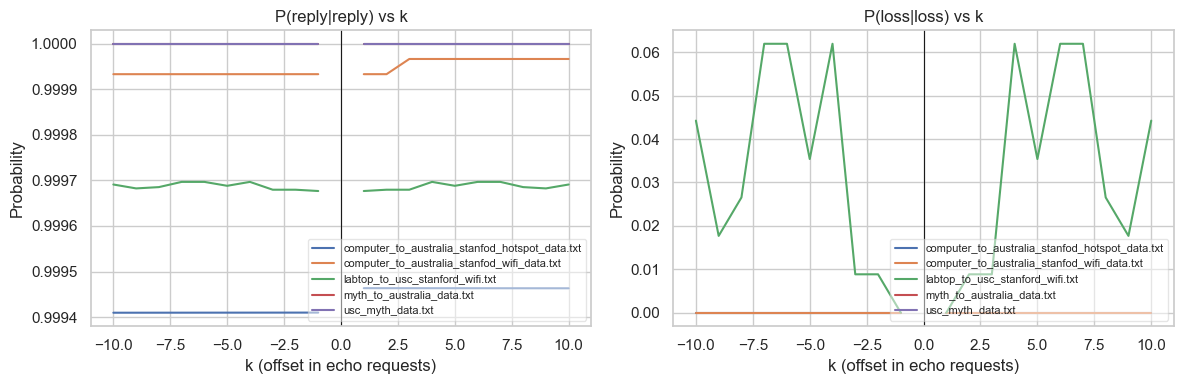

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(12,4), sharex=True, sharey=False)
autocorr_pivot.plot(ax=axes[0], title="P(reply|reply) vs k")
autocorr_loss_pivot.plot(ax=axes[1], title="P(loss|loss) vs k")
for ax in axes:
    ax.set_xlabel("k (offset in echo requests)")
    ax.set_ylabel("Probability")
    ax.axvline(0, color='k', linewidth=0.8)
    leg = ax.legend(loc="lower right", fontsize=8, frameon=True)
    leg.get_frame().set_alpha(0.5)
plt.tight_layout()


## Q6–7. Minimum and Maximum RTT over entire interval


In [35]:
rtt_stats = (
    pings[pings["success"]]
        .groupby("dataset")["rtt_ms"]
        .agg(["count","min","max","median","mean"]).reset_index()
)
rtt_stats


,dataset,count,min,max,median,mean
0,computer_to_australia_stanfod_hotspot_data.txt,18637,187.707,946.772,200.857,206.579507
1,computer_to_australia_stanfod_wifi_data.txt,29969,172.424,441.142,174.609,192.548481
2,labtop_to_usc_stanford_wifi.txt,349552,3.659,1497.123,5.586,18.592425
3,myth_to_australia_data.txt,30970,171.000,263.000,171.000,171.052793
4,usc_myth_data.txt,202,1.890,10.400,2.045,2.102921


## Q8. Graph RTT as a function of time
x-axis: actual time (approx from epoch when available, otherwise seq-based), y-axis: RTT (ms).


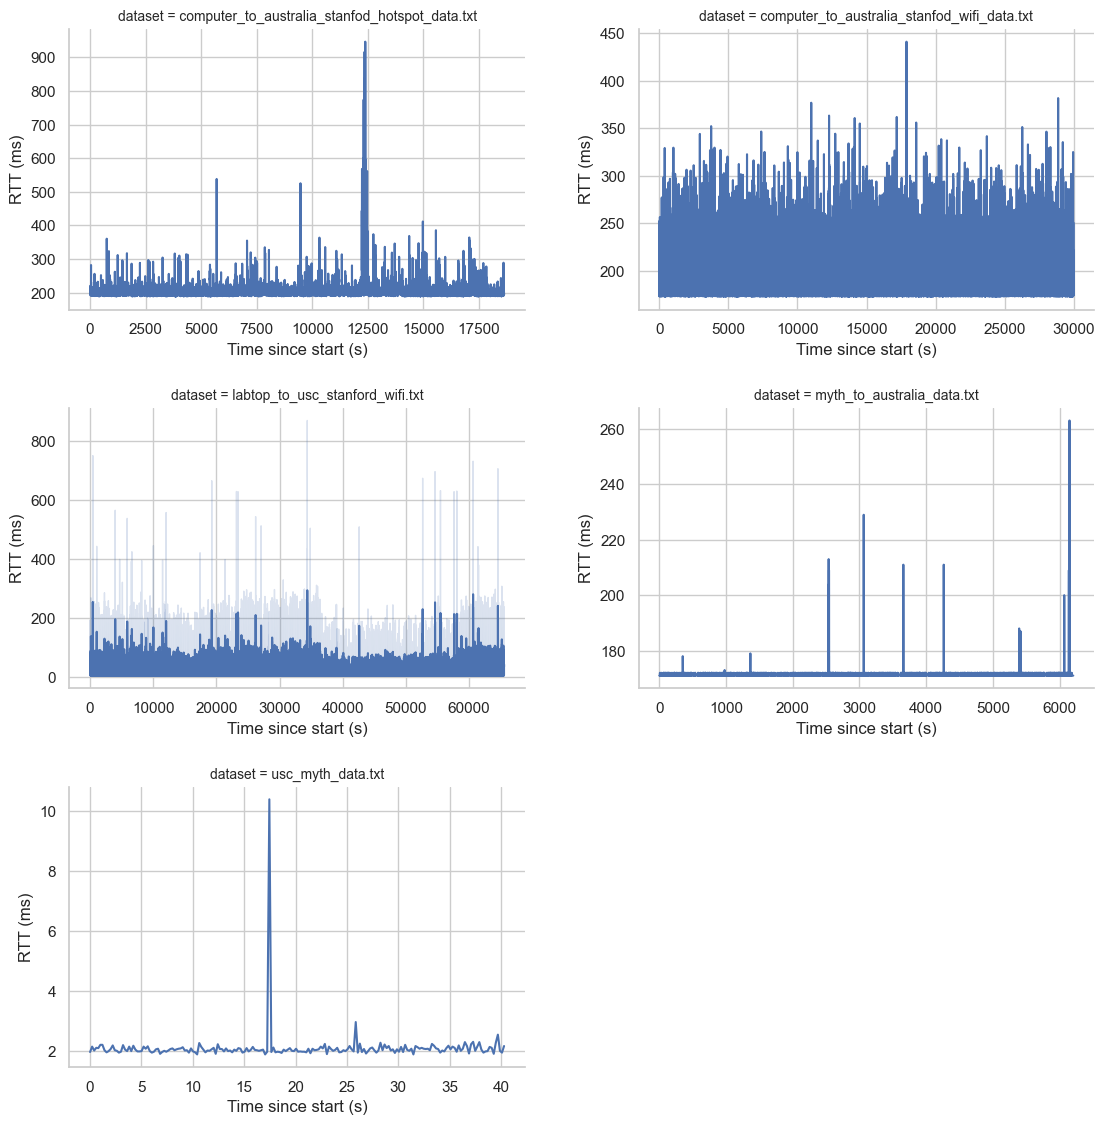

In [36]:
g = sns.relplot(
    data=pings[pings["success"]],
    x="t_sec", y="rtt_ms", col="dataset", kind="line",
    col_wrap=2, height=4, aspect=1.4,
    facet_kws=dict(sharex=False, sharey=False),
)

# Add axis labels per subplot
for ax in g.axes.flatten():
    ax.set_xlabel("Time since start (s)")
    ax.set_ylabel("RTT (ms)")

# Give more space between facets and top titles
g.fig.subplots_adjust(top=0.92, wspace=0.25, hspace=0.35)

# Make facet titles smaller and wrap if long
for ax in g.axes.flatten():
    ax.set_title(ax.get_title(), fontsize=10)

plt.show()


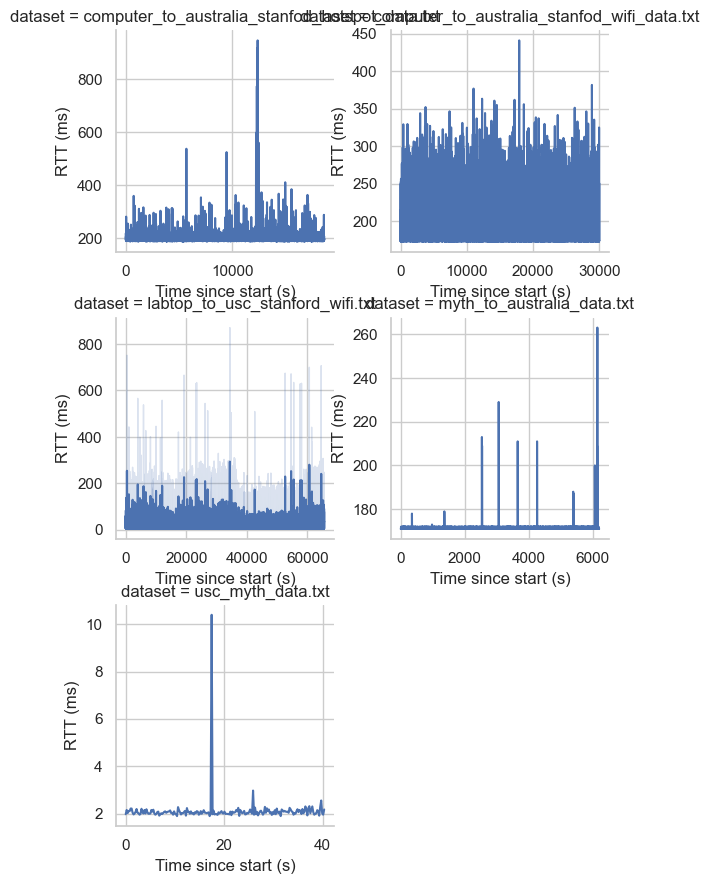

In [37]:
g = sns.relplot( 
    data=pings[pings["success"]], 
    x="t_sec", 
    y="rtt_ms", 
    col="dataset", 
    kind="line", 
    col_wrap=2, 
    height=3, 
    facet_kws=dict(sharex=False, sharey=False) 
) 

for ax in g.axes.flatten(): 
    ax.set_xlabel("Time since start (s)") 
    ax.set_ylabel("RTT (ms)") 
plt.show()

## Q9. CDF of RTTs


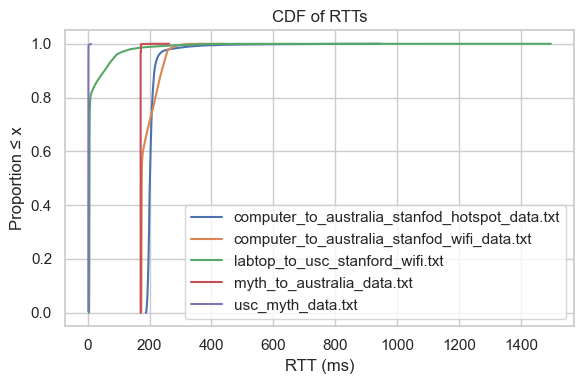

In [38]:
def plot_cdf(ax, data, label=None):
    x = np.sort(np.asarray(data))
    y = np.arange(1, len(x)+1) / len(x)
    ax.plot(x, y, label=label)

fig, ax = plt.subplots(figsize=(6,4))
for name, df in pings[pings["success"]].groupby("dataset"):
    plot_cdf(ax, df["rtt_ms"], label=name)
ax.set_xlabel("RTT (ms)")
ax.set_ylabel("Proportion ≤ x")
ax.set_title("CDF of RTTs")
ax.legend()
plt.tight_layout()


## Q10. Scatter: RTT[N] vs RTT[N+1] and correlation


/var/folders/jl/kxty9ftx6jz4jnztx5wctvt40000gn/T/ipykernel_49497/272098926.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  corrs = scatter_df.groupby("dataset").apply(lambda x: x[["rtt_ms","rtt_next"]].corr().iloc[0,1]).rename("corr").reset_index()


,dataset,corr
0,computer_to_australia_stanfod_hotspot_data.txt,0.859420
1,computer_to_australia_stanfod_wifi_data.txt,0.066485
2,labtop_to_usc_stanford_wifi.txt,0.001903
3,myth_to_australia_data.txt,0.104310
4,usc_myth_data.txt,-0.026345


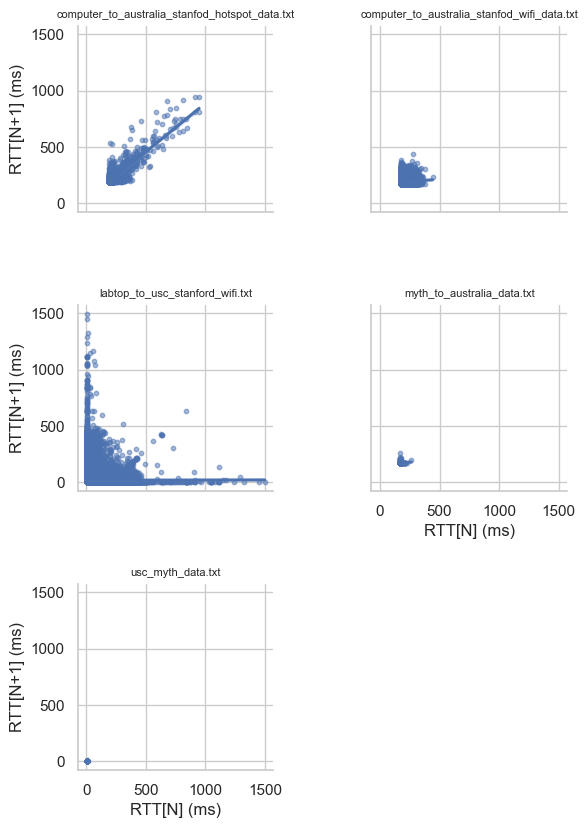

In [39]:
scatter_frames = []
for name, df in pings[pings["success"]][["dataset","seq","rtt_ms"]].groupby("dataset"):
    d = df.sort_values("seq").copy()
    d["rtt_next"] = d["rtt_ms"].shift(-1)
    scatter_frames.append(d)
scatter_df = pd.concat(scatter_frames).dropna(subset=["rtt_ms","rtt_next"]) 

# correlation per dataset
corrs = scatter_df.groupby("dataset").apply(lambda x: x[["rtt_ms","rtt_next"]].corr().iloc[0,1]).rename("corr").reset_index()

# plot
g = sns.lmplot(data=scatter_df, x="rtt_ms", y="rtt_next", col="dataset", col_wrap=2, height=3, scatter_kws=dict(s=10, alpha=0.5))
for ax in g.axes.flatten():
    ax.set_xlabel("RTT[N] (ms)")
    ax.set_ylabel("RTT[N+1] (ms)")

# Reduce title font size + add spacing between facet titles 
g.set_titles(col_template="{col_name}", size=8) 
# smaller title text 
g.fig.subplots_adjust(top=0.90, wspace=0.5, hspace=0.5) # more breathing room
    
corrs


## Q11. Throughput vs data rate experiments
We approximate data rate as `(packet_size × number_of_replies) / total_duration`. Since raw `-s`, `-i`, and `-c` settings aren't embedded, we infer per-file rate using observed replies and span of timestamps or sequence indices.


/var/folders/jl/kxty9ftx6jz4jnztx5wctvt40000gn/T/ipykernel_49497/3313088552.py:75: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["t_sec"] = df["epoch_ts"].fillna(method="ffill").fillna(method="bfill") - t0
/var/folders/jl/kxty9ftx6jz4jnztx5wctvt40000gn/T/ipykernel_49497/3313088552.py:75: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["t_sec"] = df["epoch_ts"].fillna(method="ffill").fillna(method="bfill") - t0


,dataset,packet_size_bytes,total_sent,replies,loss_rate,duration_s,requests_per_s,replies_per_s,request_data_rate_Bps,reply_data_rate_Bps,request_data_rate_Mbps,reply_data_rate_Mbps
0,australia_high_speed_data_laptop_wifi.txt,56,689,689,0.0,6.88,100.145349,100.145349,5608.139535,5608.139535,0.044865,0.044865
1,australia_myth_high_speed_data.txt,56,742,742,0.0,7.41,100.134953,100.134953,5607.557355,5607.557355,0.044860,0.044860
2,usc_high_speed_data_laptop_wifi.txt,56,682,682,0.0,6.81,100.146843,100.146843,5608.223201,5608.223201,0.044866,0.044866
3,usc_myth_high_speed_data.txt,56,847,847,0.0,8.46,100.118203,100.118203,5606.619385,5606.619385,0.044853,0.044853


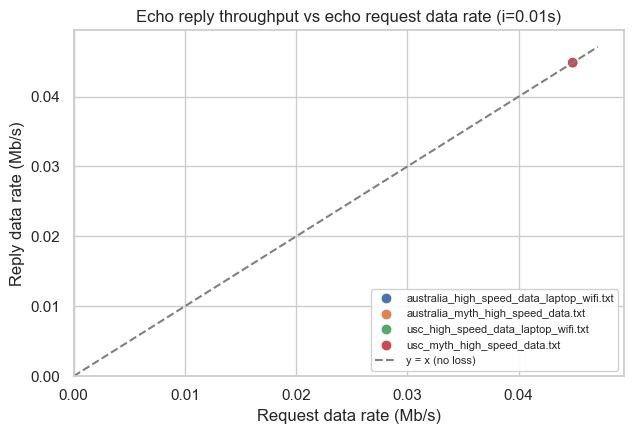

Max reply throughput: 0.04 Mb/s (5608 B/s) in usc_high_speed_data_laptop_wifi.txt with packet size 56 bytes.


In [40]:
# Q11 — High-rate experiments (interval = 0.01s)
HS_DIR = "/Users/nickallen/Documents/GitHub/CS144/data/high_speed_data"
HS_INTERVAL = 0.01 

from glob import glob

HEADER_MAC_RE = re.compile(r"^PING .*: (?P<size>\d+) data bytes")
HEADER_LINUX_RE = re.compile(r"^PING .* (?P<size>\d+)\(\d+\) bytes of data\.$")

def infer_packet_size_bytes(path: str, default: int = 56) -> int:
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            m = HEADER_MAC_RE.match(line)
            if m:
                return int(m.group("size"))
            m = HEADER_LINUX_RE.match(line)
            if m:
                return int(m.group("size"))
            # stop early if we pass the header
            if line.startswith("64 bytes from") or "icmp_seq=" in line:
                break
    return default

hs_files = sorted(glob(os.path.join(HS_DIR, "*.txt")))
hs_rows = []
for pf in hs_files:
    df = parse_ping_file(pf)
    if df.empty:
        continue
    size_bytes = infer_packet_size_bytes(pf, default=56)
    seq_min, seq_max = int(df["seq"].min()), int(df["seq"].max())
    total_sent = seq_max - seq_min + 1
    # duration using known interval between requests
    duration_s = max((total_sent - 1) * HS_INTERVAL, 1e-6)
    replies = int(df["success"].sum())
    loss_rate = 1.0 - (replies / total_sent)
    # rates
    req_rate = total_sent / duration_s              
    rep_rate = replies / duration_s                       
    req_bps = size_bytes * req_rate                
    rep_bps = size_bytes * rep_rate                        
    hs_rows.append({
        "dataset": os.path.basename(pf),
        "packet_size_bytes": size_bytes,
        "total_sent": total_sent,
        "replies": replies,
        "loss_rate": loss_rate,
        "duration_s": duration_s,
        "requests_per_s": req_rate,
        "replies_per_s": rep_rate,
        "request_data_rate_Bps": req_bps,
        "reply_data_rate_Bps": rep_bps,
        "request_data_rate_Mbps": req_bps * 8 / 1e6,
        "reply_data_rate_Mbps": rep_bps * 8 / 1e6,
    })

hs_summary = pd.DataFrame(hs_rows).sort_values("dataset").reset_index(drop=True)
display(hs_summary)

# Plot reply data rate vs request data rate, with y=x reference
fig, ax = plt.subplots(figsize=(6.5, 4.5))
sns.scatterplot(
    data=hs_summary,
    x="request_data_rate_Mbps", y="reply_data_rate_Mbps",
    hue="dataset", s=60, ax=ax
)
max_x = hs_summary["request_data_rate_Mbps"].max() * 1.05
ax.plot([0, max_x], [0, max_x], linestyle="--", color="gray", label="y = x (no loss)")
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.set_xlabel("Request data rate (Mb/s)")
ax.set_ylabel("Reply data rate (Mb/s)")
leg = ax.legend(loc="lower right", fontsize=8, frameon=True)
leg.get_frame().set_alpha(0.9)
ax.set_title("Echo reply throughput vs echo request data rate (i=0.01s)")
plt.tight_layout()
plt.show()

# Maximum throughput achieved
max_row = hs_summary.loc[hs_summary["reply_data_rate_Bps"].idxmax()]
print(
    f"Max reply throughput: {max_row['reply_data_rate_Mbps']:.2f} Mb/s "
    f"({max_row['reply_data_rate_Bps']:.0f} B/s) in {max_row['dataset']} "
    f"with packet size {max_row['packet_size_bytes']} bytes."
)


The data rate does not level out and was consistent through all tests. 

## Q12. Conclusions from the data
The differences between wired and unwired was super surprising. The wired myth test was almost always exaclty 171ms without much variance. This stayed consistent over the short distance to USC. It was super interesting to gain insight into the reliability of wifi by constrating it with the wired connection. It was also interesting to look at wifi versus cellular data. Australia transmission with wifi versus cellular, wifi was more consitent with lower RTTs than cellular showing it is more robust. What really surprised me was the amount of variance we saw when sending messages from Stanfrord wifi to USC. While this test was longer than others, there was far far worse preformance compared to the data transmissions on the wired machine to USC. Thus, I was surprised to learn overall that variance in the data transmission time can be attributed to the type of connection (wired / wireless). While actual base time is extremely closely tied with how far the package is actually traveling. 

## Q13. Interesting comparisons between paths and other network paths



In terms of difference between the paths, it was interesting to see that the first hop from laptop to australia and myth to australia were different. However, the both evenutally go through an address starting with 171.64 that is some kind of SUNET network. They also both leave Stanford in the same manner, hitting the 137.164.27.60 router. After this point, the path is the same, which makes sense that they both find the optimal path once a common node is reached. We saw similar behavoir with USC from myth versus wifi. They start off in different stanford networks but after the first hop after stanford they find the same path, which I would assume is the optimal path to the desitnation. Given that I ran these tests at different times, it is intersting that the congestion / network state at the time doesn't lead towards different optimal paths. There were also many entries with ***. I did not necessarily know if this was an explicit hop, or if the traceroute function couldn't read from these endpoints. I did not have a very good idea what to make of these lines and how to incorporate them into my analysis. 